In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import talib

np.set_printoptions(suppress=True)

import sys, os
sys.path.append("../src")

from helpers import build_distance_matrix
from macro_models import batched_gaussian_process
from priors import diffusion_prior, length_scale_prior
from micro_models import dynamic_batch_diffusion, fast_dm_simulate, diffusion_trial
from networks_10092022 import DynamicGaussianNetworkFactorized
from context import generate_design_matrix
from transformations import unscale_z, scale_z

In [4]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow.keras.layers import GRU, Dense, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from functools import partial

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))


# physical_devices = tf.config.list_physical_devices('CPU')
# tf.config.set_visible_devices([], 'GPU')
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [5]:
T = 3200
N_PARAMS = 6
DIST_MAT = build_distance_matrix(T)
# AMPLITUDES = [0.20, 0.20, 0.20, 0.20, 0.20, 0.15]
AMPLITUDES = [0.15, 0.15, 0.15, 0.15, 0.1, 0.05]

BATCH_SIZE = 16
TEST_SIZE = 10
N_CHUNKS = 4000
EPOCHS = 100

Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



2022-11-01 17:37:26.950905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-01 17:37:26.951473: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
PARAMS_MEAN = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0,
               1.2, 1.2, 1.2, 1.2, 1.2, 0.3]
PARAMS_STD = [2.75, 2.75, 2.75, 2.75, 2.75 , 2.75,
              1.0, 1.0, 1.0, 1.0, 1.0, 0.25]

In [7]:
EMPIRIC_COLOR = '#1F1F1F'
NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'

In [8]:
# def generator_fun(batch_size):
#     theta0 = diffusion_prior(batch_size, n_cond=4)
#     eta = length_scale_prior(batch_size, 6)
#     eta_t = np.stack([eta] * T, axis=1)
#     theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
#     context = generate_design_matrix(batch_size, T)
#     rt = dynamic_batch_diffusion(theta_t, context)
#     x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

#     params_t = np.concatenate([eta_t, theta_t], axis=-1)
#     params_t_z = (params_t - PARAMS_MEAN) / PARAMS_STD
    
#     return params_t_z.astype(np.float32), x.astype(np.float32)

In [11]:
def generator_fun(batch_size):
    theta0 = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
    eta = length_scale_prior(batch_size, N_PARAMS)
    theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
    context = generate_design_matrix(batch_size, T)

    rt = dynamic_batch_diffusion(theta_t, context)
    x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    # eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)

    return eta.astype(np.float32), theta_t.astype(np.float32), x.astype(np.float32)

In [12]:
eta, theta_t, x = generator_fun(100)

In [13]:
theta_t.shape

(100, 3200, 6)

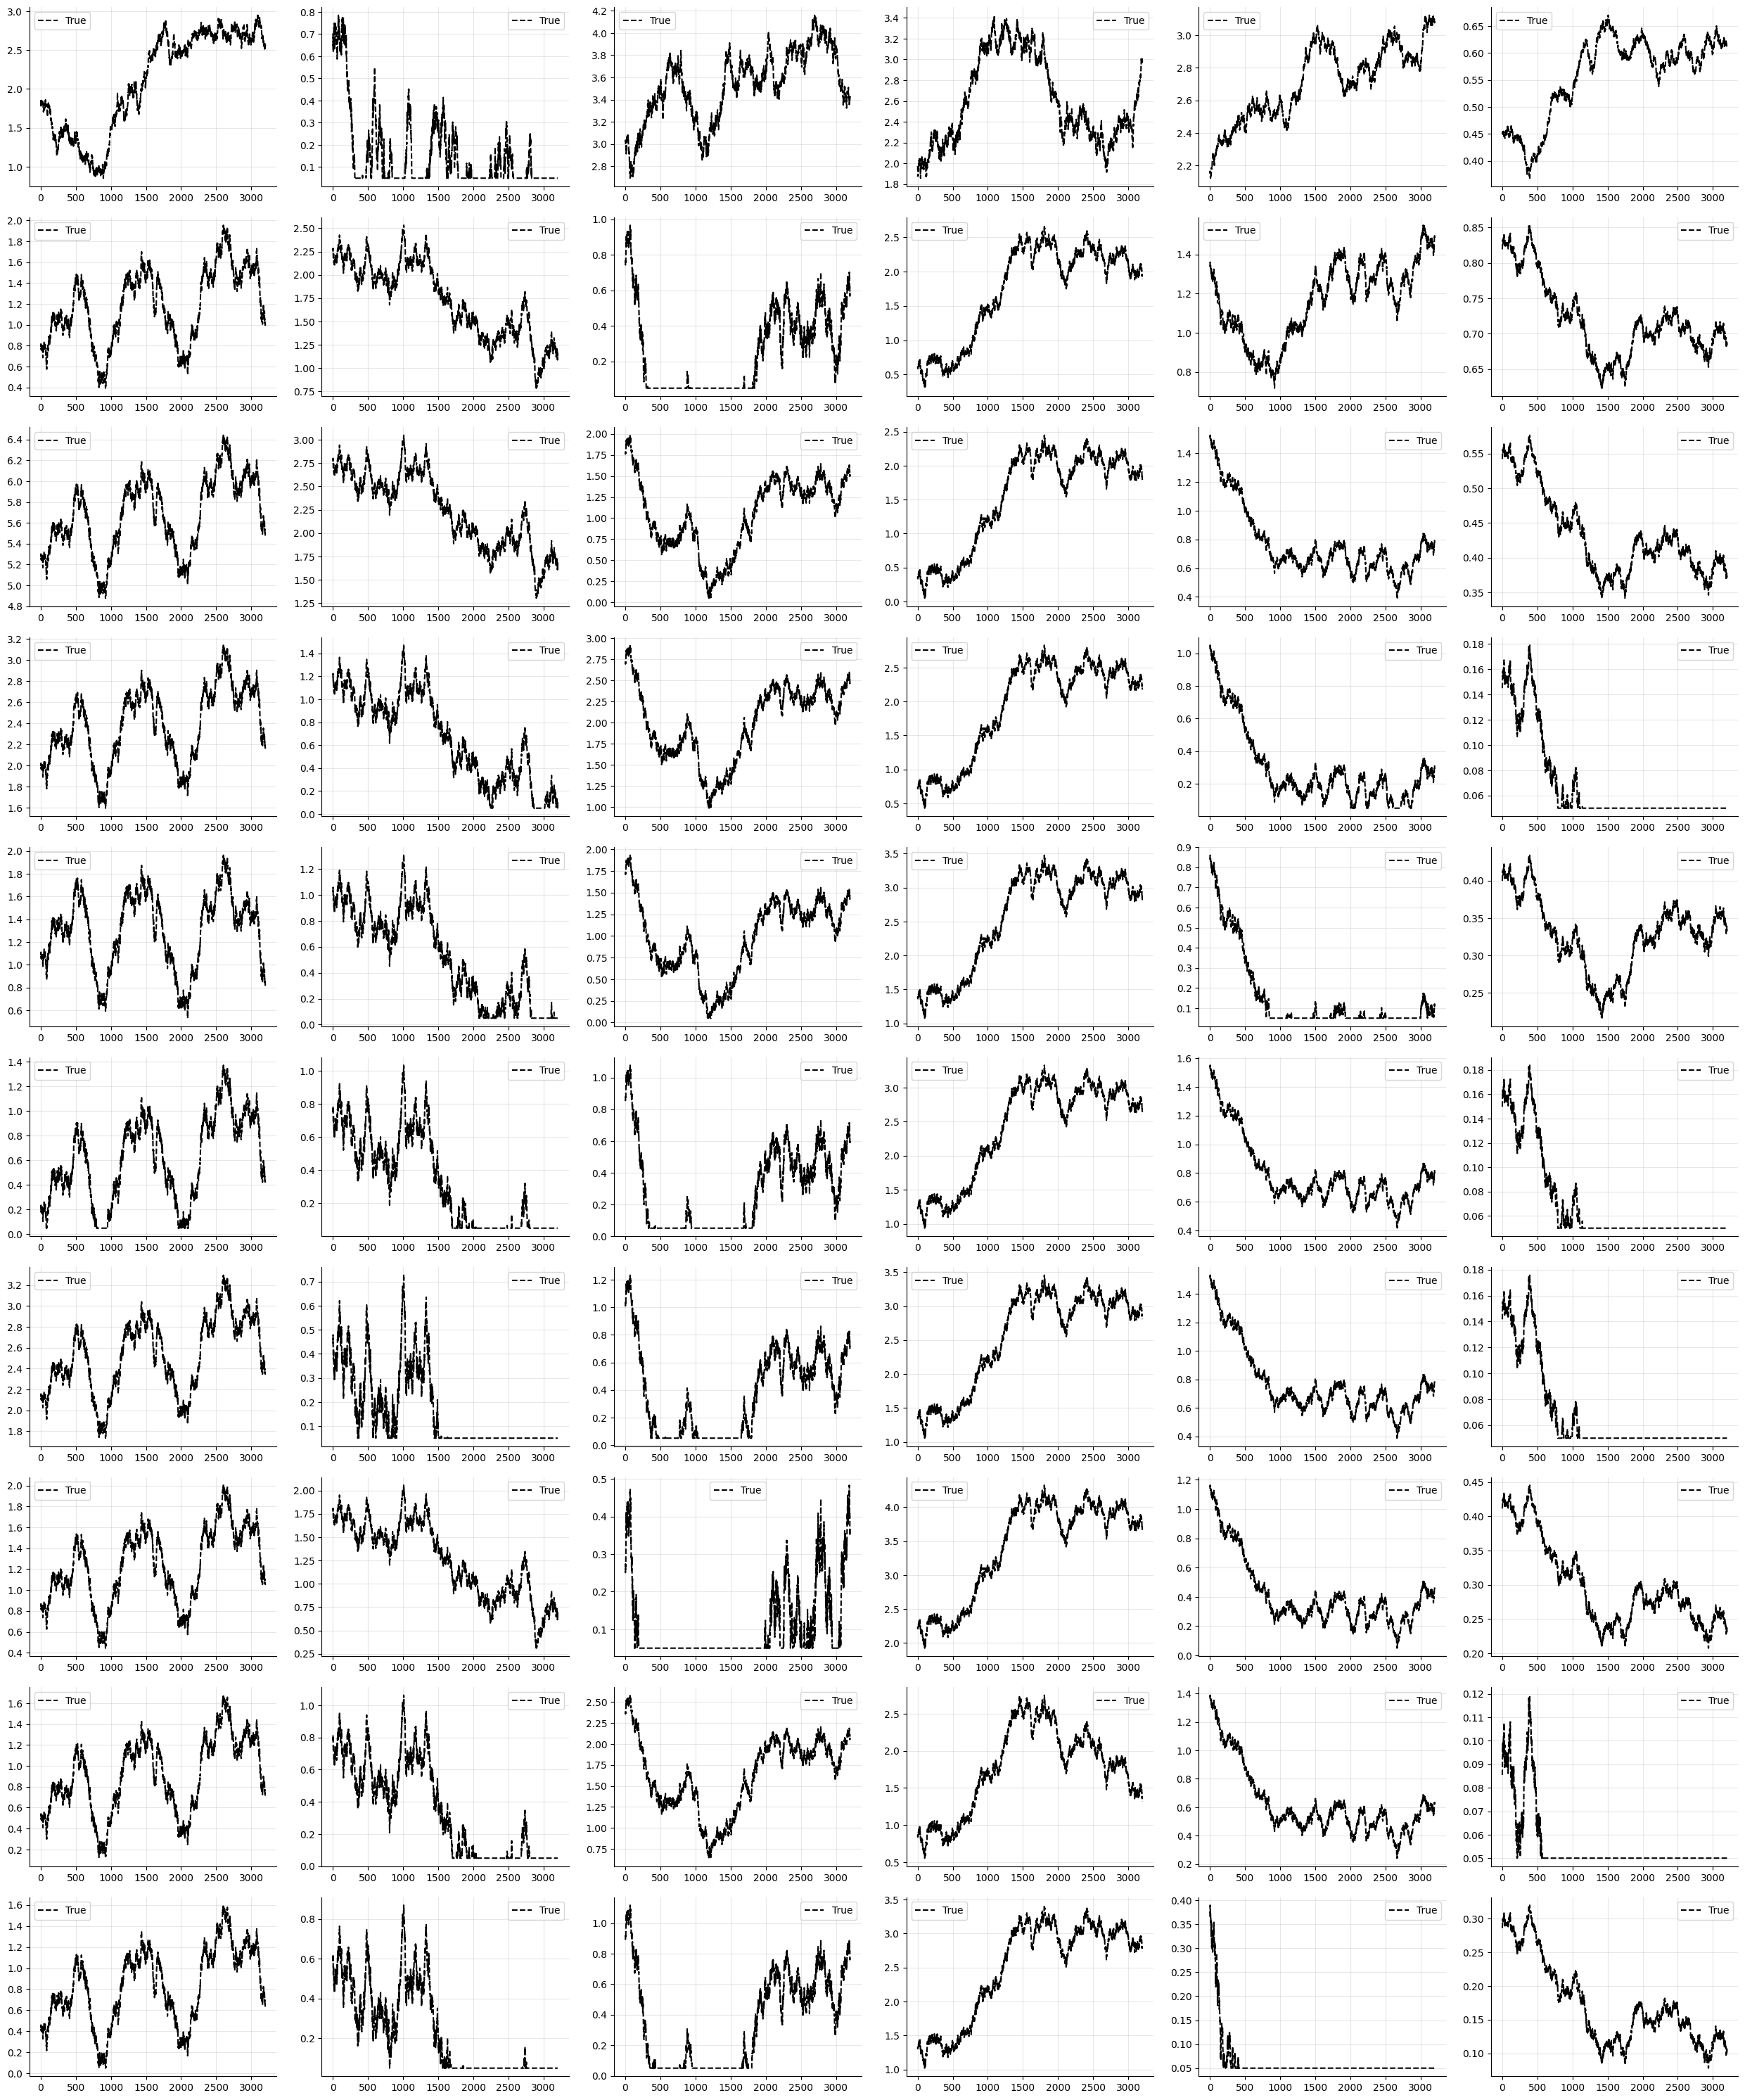

In [14]:
f, axarr = plt.subplots(10, 6, figsize=(25, 30))
time = np.arange(1, theta_t.shape[1]+1)
for j in range(10):
    for i in range(6):
        ax = axarr[j, i]
        ax.plot(time, theta_t[j, :, i], label='True', color='black', linestyle='dashed')
        sns.despine(ax=ax)
        ax.legend()
        ax.grid(alpha=0.3)
f.tight_layout()